In [ ]:
#一些常用的命令
!nvidia-smi

In [ ]:
#一些常用的命令
!git status
!git add .
!git commit -m "correct and optimize some code"
!git push

In [ ]:
########################################################################################################################
print("0.主程序开始，建立多层嵌套决策树模型，3080ti的GPU是AMD2400CPU 运算速度100倍")
print("0.这是简化程序，原始带有更多测试和原始模型的程序在mainTestCSVMLP3(hmcnf_keras).ipynb")
print("0.这是简化程序，只训练和测试5label模型,编号为0")
########################################################################################################################
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn import tree
#import graphviz 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
import copy
from imblearn.over_sampling import RandomOverSampler

import pickle  

########################################################################################################################
#######开始为功能函数
#######函数用于决策树分析

def dtFitAndSave(x,y,saveName):
    str1="dtFitAndSave,用于决策树拟合和识别"
    
    dt = tree.DecisionTreeClassifier(max_depth=7,min_samples_leaf=100)
    dt = dt.fit(x, y)
    tree.plot_tree(dt)
    #data=tree.export_graphviz(dt, out_file=None,class_names=None,filled=True) 
    #graph = graphviz.Source(data)
    #graph.render(saveName)
    
    yPredict = dt.predict(x)
    tmp1 = classification_report(y,yPredict)
    print("纯决策树的识别\n",tmp1)
    mat1num = confusion_matrix(y,yPredict)
    mat2acc = confusion_matrix(y,yPredict,normalize='pred')
    print(mat1num)
    print(np.around(mat2acc , decimals=3))
    #text_representation = tree.export_text(dt)
    #print(text_representation)
    #yPredict = dt.predict_proba(x)
    #index = np.where((yPredict[:,1]<0.98)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.90)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.80)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.70)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    return dt,yPredict

########################################################################################################################
###简单模型3，resnet_like

def global_model(dropout_rate, relu_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(relu_size, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    return model

def sigmoid_model(label_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(label_size, activation='sigmoid',name="global"))
    return model

def kerasFitAndSaveSimple3LikeResnet(x,yOneHot,num_labels,saveName):
    str1="kerasFitAndSaveSimple3LikeResnet,用于resnet_like的神经网络拟合和识别"
    
    nSamples,features_size = x.shape
    relu_size = 512
    dropout_rate = 0.05
    hierarchy = [1,1,1]#三层，对于当前数据集已经足够了
    global_models = []
    label_size = num_labels
    features = layers.Input(shape=(features_size,))
    for i in range(len(hierarchy)):
        if i == 0:
            global_models.append(global_model(dropout_rate, relu_size)(features))
        else:
            global_models.append(global_model(dropout_rate, relu_size)(layers.concatenate([global_models[i-1], features])))

    p_glob = sigmoid_model(label_size)(global_models[-1])
    build_model = tf.keras.Model(inputs=[features], outputs=[p_glob])
    #model = tf.keras.Model(inputs=[features], outputs=[build_model])
    #enc = OneHotEncoder()
    #enc.fit(y)  
    #yOnehot=enc.transform(y).toarray()
    build_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
    if 1:
       build_model = keras.models.load_model(saveName)
    
    #build_model.fit([x],[yOneHot],epochs=10, batch_size=10000*1)
    build_model.fit(x,yOneHot,epochs=15000, batch_size=20000*1)#GPU用这个
    #saveName = "KerasSimple3_likeResnet.h5"
    build_model.save(saveName)
    #plot_model(build_model, to_file='KerasSimple3_likeResnet.png', show_shapes=True)
    return build_model
########################################################################################################################
def getKerasResnetRVL(x,enc,saveName):
    model_name = saveName 
    model = keras.models.load_model(model_name)
    y= model.predict([x], batch_size=2560)
    nSamples = y.shape[0]
    ###需要将预测出的值，转换01整数,并转为数字式
    for i in range(y.shape[0]):
        tmp = y[i]
        index=  np.argmax(tmp)
        y[i] = [0]*y.shape[1]
        y[i,index]=1
   

    ###  
    y= enc.inverse_transform(y)
    y= y.reshape(-1,nSamples)[0]
    
    
    return y

def string2int(inputString):
     #print(inputString)
     tmp = 0
     try:
         strTmp=[str(ord(x)) for x in inputString]
         tmp=tmp.join(strTmp)
         tmp = float(tmp)/(len(inputString)*128)
     except:
         #print(inputString)
         strTmp = inputString
         tmp= "0"
         tmp = 0
     return tmp
########################################################################################################################
########################################################################################################################
print("0.主程序开始，建立多层嵌套决策树模型，3080ti的GPU是AMD2400CPU 运算速度100倍")
########################################################################################################################

print("reading data france,读取数据并且把数据进行onehot处理")
file1 = "./trainData/france_0_allSamples1.csv"

xyDataTmp = pd.read_csv(file1)
#print(xyDataTmp.info())
xyData = np.array(xyDataTmp)
h,w = xyData.shape
#x = xyData[:,1:23]#简单处理与SUMO数据库一致
x0rigin = xyData[:,1:w-1]#用所有的数据
y0rigin  = xyData[:,w-1]

x0rigin[:,6] = [string2int(inputString) for inputString in x0rigin[:,6] ]#字符串vehLaneID 变为整数

x0rigin =x0rigin.astype(np.float32)#GPU 加这个
y0rigin =y0rigin.astype(np.int64)#GPU 加这个


ros = RandomOverSampler(random_state=0)
x0,y0= ros.fit_resample(x0rigin , y0rigin)#对数据不平衡进行处理，保证样本数一致

x0=x0.astype(np.float32)#GPU 加这个
y0=y0.astype(np.int64)#GPU 加这个
yl5 = y0
print("x0.shape:",x0.shape,"y0.shape:",y0.shape,"y0.type:", type(y0) )
del xyDataTmp #节省内存
del xyData #节省内存




########################################################################################################################
print("准备字典，用于保存训练后的数据")

xFloors=  dict()
yFloors =  dict()
dtModeFloors=  dict()
dtPredictLabel = dict()
kerasPredictLabel = dict()
kerasModelNameFloors =dict()
encFloors= dict()
########################################################################################################################
###现在暂时不训练多层模型，只训练5label模型
if 1:
    print("5label 模型")
    x=x0
    y=yl5
    x=x.astype(np.float32)#GPU 加这个
    y=y.astype(np.int64)#GPU 加这个
    print("x.shape:",x .shape,"y.shape:",y .shape,"y.type:", type(y) )
    
    num_labels = 5 
    nSamples,nFeatures =  x.shape
    enc = OneHotEncoder()
    y= y.reshape(nSamples,-1)
    
    print("y.shape:",y .shape,"y.type:", type(y) )
    enc.fit(y)
    yOneHot=enc.transform(y).toarray()
    #saveName = "hybrid2_KerasSimple3_likeResnet_5label.h5"
    saveName = "./4LayerModelGPU/model-4lays-512nodes1.h5"
    if 0:
        kerasModel3_5label = kerasFitAndSaveSimple3LikeResnet(x,yOneHot,num_labels,saveName)     
    yKeras_5label=getKerasResnetRVL(x,enc,saveName)
    
    print('keras\n')
    mat1num = confusion_matrix(y, yKeras_5label)
    mat2acc = confusion_matrix(y, yKeras_5label,normalize='pred')
    print('mat1num\n',mat1num)
    print('mat2acc\n',np.around(mat2acc , decimals=3))
    
    
    
    
    dt_5label,dt_PredictLabel = dtFitAndSave(x,yl5,"5label")
    enc_5label = enc
    
    xFloors[0] =  x.copy()
    yFloors[0] =  y.copy()
    dtModeFloors[0] =  dt_5label
    dtPredictLabel[0] = dt_PredictLabel.copy()
    kerasPredictLabel[0] = yKeras_5label.copy()
    kerasModelNameFloors[0] =saveName
    encFloors[0] = enc_5label


In [ ]:
########################################################################################################################
print("1.接编号为0的主程序,对于输入的一个样本识别与各个类别的距离，并转换为概率")
print("2.对较低概率的样本进行蒙特卡洛模拟分析，原始对应程序为mainSimSumoFranceDatra")
print("3.程序编号为1")
########################################################################################################################
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn import tree
#import graphviz 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
import copy
from imblearn.over_sampling import RandomOverSampler
import pickle

import warnings
warnings.filterwarnings("ignore")
########################################################################################################################
###自定义log,用于记录
def log(info,logtype=0):
    
    #*args
    if logtype == -1:
        return
    if logtype == 0:
        print(info)        


    
########################################################################################################################
print("1.1 主程序开始，接编号为0的主程序,对于输入的一个样本识别与各个类别的距离，并转换为概率")
########################################################################################################################
logtype=0

xi=x0
yi=yl5
modeSaveName = "hybrid2_KerasSimple3_likeResnet_5label.h5"
model = keras.models.load_model(modeSaveName)
yout= model.predict([xi], batch_size=2560)
#log(xi,logtype)
#log(yi,logtype)
#log(yout,logtype)
ymax1=np.max(yout,axis=1)
index = np.where(ymax1<0.95)[0]#提取最大值小于0.95的例子
ylowpraPredictNN=yout[index]#对较低概率的样本
xlowpra=xi[index]
ylowpraLabel = yi[index]
#log(xi,logtype)
#log(yi,logtype)
#log(ylowpra)
#log(xlowpra)
#log(index)

    
#######保存为pickle文件

##保存低概率的样本
fpk=open('lowprobSamples.pkf','wb+')  
pickle.dump([index,xlowpra,ylowpraLabel,ylowpraPredictNN],fpk)  
fpk.close() 
del xlowpra,ylowpraLabel
fpk=open('lowprobSamples.pkf','rb')   
[index1,xlowprob1,ylowprobLabel1,ylowprobPredictNN1]=pickle.load(fpk)  
fpk.close()  


log(index1)
#log(ylowprobLabel1)
log(np.round(ylowprobPredictNN1,2))

##保存所有的的样本
fpk=open('allSamples5label.pkf','wb+')  
pickle.dump([x0,yl5,yout],fpk)  
fpk.close() 

fpk=open('allSamples5label.pkf','rb')   
[x0tmp,yl5tmp,ykerasNNtmp]=pickle.load(fpk)  
fpk.close()  

#log(np.round(ykerasNNtmp,2))

In [ ]:
########################################################################################################################
print("接程序1.1: 1.2 对较低概率的样本进行蒙特卡洛模拟分析,原始对应程序为mainSimSumoFranceDatra")
print("因为配置失误，采用将低概率的样本进行保存为文件，然后再root用户下命令行模式用SUMO模拟（不使用conda）")
########################################################################################################################
!python runSumoSimFun.py#运行runSumoSimFun.py 中test2

In [ ]:
########################################################################################################################
print("接程序1.2: 1.3 对较低概率的样本进行蒙特卡洛模拟分析,将数据存为pickle文件")
print("因为配置失误，采用将低概率的样本进行保存为文件，然后再root用户下命令行模式用SUMO模拟（不使用conda）")
########################################################################################################################

!python3 runSumoSimFun.py
#运行runSumoSimFun.py 中test3

接程序1.3: 1.4 对模拟后的数据进行分析，计算正确率
对于低概率样本的识别结果，采用keras和MCS的识别结果对比
       originIndex  origin speedFlag  predicted Labels By kerasNN  \
index                                                               
0               10                 0                            0   
1               12                 0                            0   
2               14                 0                            0   

       predicted Labels By MCS  
index                           
0                            0  
1                            0  
2                            0  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 65728 entries, 0 to 65914
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   originIndex                  65728 non-null  int64
 1   origin speedFlag             65728 non-null  int64
 2   predicted Labels By kerasNN  65728 non-null  int64
 3   predicted Labels By MCS      65728

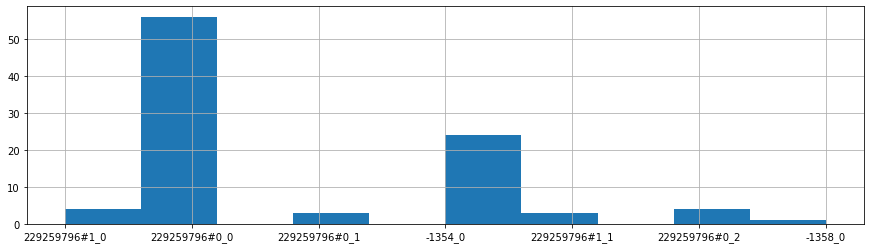

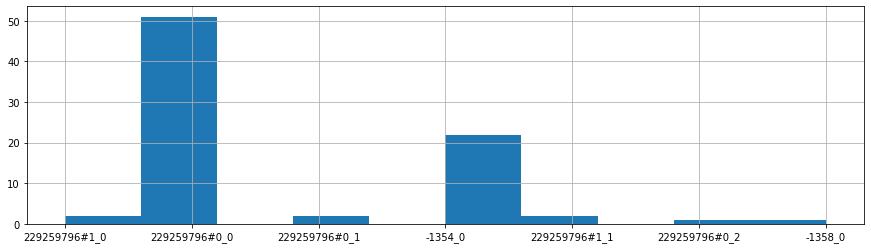

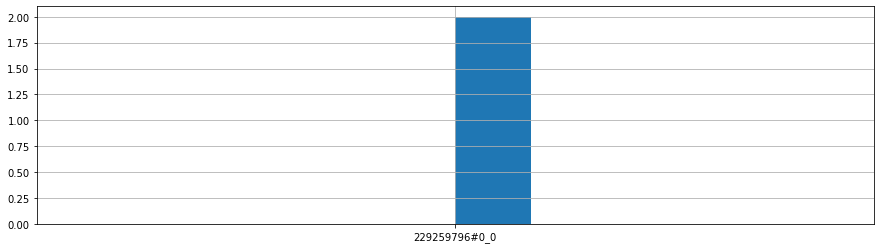

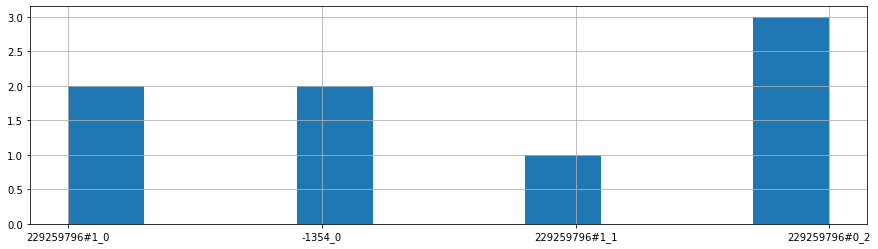

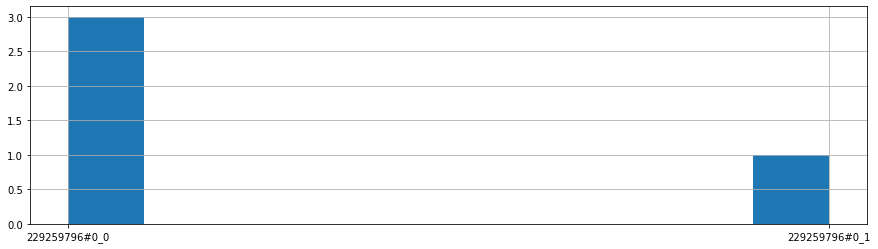

In [208]:
########################################################################################################################
print("接程序1.3: 1.4 对模拟后的数据进行分析，计算正确率")
########################################################################################################################

import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report    
import numpy as np
import matplotlib.pyplot as plt
print("对于低概率样本的识别结果，采用keras和MCS的识别结果对比")
file1 = "./data-Copy1.csv"
xyDataTmp = pd.read_csv(file1,index_col=0)

print(xyDataTmp.head(3))
print(xyDataTmp.info())

file1 = "./trainData/france_0_allSamples1.csv"
xyOrigin = pd.read_csv(file1,index_col=0)

originlabel =  xyDataTmp.iloc[:,1].to_numpy()
keraslabel =   xyDataTmp.iloc[:,2].to_numpy()      
mcslabel =     xyDataTmp.iloc[:,3].to_numpy()

#
    
print('\norigin_mcs')
mat1num = confusion_matrix(originlabel, mcslabel)
mat2acc = confusion_matrix(originlabel, mcslabel,normalize='pred')
print('mat1num\n',mat1num)
print('mat2acc\n',np.around(mat2acc , decimals=3))
      
print('\nmcs_keras')
mat1num = confusion_matrix(mcslabel, keraslabel)
mat2acc = confusion_matrix(mcslabel, keraslabel,normalize='pred')
print('mat1num\n',mat1num)
print('mat2acc\n',np.around(mat2acc , decimals=3))

print('\norgin_keras')
mat1num = confusion_matrix(originlabel, keraslabel)
mat2acc = confusion_matrix(originlabel ,keraslabel,normalize='pred')
print('mat1num\n',mat1num)
print('mat2acc\n',np.around(mat2acc , decimals=3))      

##用于分析实际标记类别大于预测标记类别
def analyzing1(tmp, xyDataTmp,xyOrigin): 
    dfTmp1 = xyDataTmp[tmp]
    #print(dfTmp1.head(5))
    
    
    
    df2 =  xyOrigin.iloc[dfTmp1.originIndex,:]   
    plt.show()
    df2["vehLaneID"].hist(figsize=(15, 4))
    #print(df2.info())
    print("df2 origin Shape:",df2.shape)
    
    df2.to_csv("tmpForAnalyzing.csv")
    
    tmp1 = df2['redLightTime'] - df2['arriveTime2'] >1.5 #红灯时间大于到达时间
    df3 = df2[tmp1]
    print("df3 = df2[df2['redLightTime'] - df2['arriveTime2'] >1.5] #红灯时间大于到达时间 ,df3 shape:",df3.shape)
    print("df2 origin Shape:",df2.shape)
    df3.to_csv("tmpForAnalyzing3.csv")
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4))   
    
   
    tmp1 = df2['speed'] < 5/3.6 #本身速度就小于5/3.6
    df3 = df2[tmp1]
    print("df2['speed'] > 5/3.6 #本身速度就小于5/3.6,df3 shape:",df3.shape)
    print("df2 origin Shape:",df2.shape)
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4))   
    df3.to_csv("tmpForAnalyzing4.csv")
    
    tmp1 = df2['redLightTime'] - df2['arriveTime2'] >1.5  #红灯时间大于到达时间
    tmp1 = tmp1 | (df2['speed'] < 5/3.6) #本身速度就小于5/3.6
    df3 = df2[tmp1]
    print("红灯时间大于到达时间  or 本身速度就小于5/3.6,df3 shape:",df3.shape,"占输入样本比例为:",df3.shape[0]/df2.shape[0])
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4))   
    df3.to_csv("tmpForAnalyzing5.csv")
    
    
    tmp1 = df2['arriveTime2'] - df2['redLightTime'] >0 #到达时间大于红灯时间
    tmp1 = tmp1 & (df2['speed'] > 5/3.6) #本身速度就大于于5/3.6
    tmp1 = tmp1 & (df2['vehPos_2'] > 0) #
    tmp1 = tmp1 & (df2['vehSpeed_2'] < 5/3.6) #
    tmp1 = tmp1 & (df2['vehPos_3'] >0) #
    tmp1 = tmp1 & (df2['vehSpeed_3'] <5/3.6) #
    
    df3 = df2[tmp1]
    print("到达时间大于红灯时间  and 本身速度就大于5/3.6,df3 shape:",df3.shape,"占输入样本比例为:",df3.shape[0]/df2.shape[0])
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4))   
    df3.to_csv("tmpForAnalyzing6.csv")

def extractStillVeh2(df):
    df=df.rename(columns={'ArrTimeDivRedTime':'numStillVeh'})
    df=df.rename(columns={'lanAvgSpeed':'predictStats'})
    df['numStillVeh'] = 0
    df['predictStats'] = "unknown"
    for i in range(df.shape[0]):
        numStillVeh = 0
        tmp = df.iloc[i]
        redTime = tmp.iloc[0]
        vPosObj = tmp.iloc[1]
        predictStats = -1

        for j in range(20):
           
            vehPos = tmp.iloc[2*j+8]
            vehVeh = tmp.iloc[2*j+1+8]
            
            if vehPos >0 and vehVeh<5/3.6:#经验数据,参数
                numStillVeh = numStillVeh + 1
            elif vehPos >0 and  vPosObj > vehPos:
                timeTmp1 =(vehPos-j*6.5)/(vehVeh+0.001)#经验公式，到固定位置后，启动需要的时间
                if timeTmp1  < redTime +numStillVeh*1.5:
                    numStillVeh = numStillVeh + 1

            if vehPos >0 and vPosObj == vehPos and vehVeh<5/3.6:
                predictStats = "stop"#目标车要听停止
               

            if vehPos >0 and vPosObj == vehPos and vehVeh>5/3.6 :    
                timeTmp1 =(vehPos-j*6.5)/(vehVeh+0.001)#经验公式，到固定位置后需要的时间
                if timeTmp1  <= redTime +numStillVeh*1.5+1.5:#小于虚拟红灯结束时间
                     predictStats = "stop" #目标车要听停止
                else:        
                     predictStats = "no stop"  #目标车要不要停止
                
     
        df['numStillVeh'][i] = numStillVeh
        df['predictStats'][i] = predictStats

    return df
##用于分析实际标记类别小于预测标记类别， xyDataTmp["predicted Labels By MCS"] - xyDataTmp["origin speedFlag"]>0
def analyzing2(tmp, xyDataTmp,xyOrigin): 
    dfTmp1 = xyDataTmp[tmp]
    #print(dfTmp1.head(5))
    
    
    #1
    df2 =  xyOrigin.iloc[dfTmp1.originIndex,:]   
    plt.show()
    df2["vehLaneID"].hist(figsize=(15, 4))
    #print(df2.info())
    print("df2 origin Shape:",df2.shape)
    df2 = extractStillVeh2( df2)
    df2.to_csv("tmpForAnalyzing.csv")
    
    
    ######################################
    tmp1 = (df2['speedFlag'] == 0)  & (df2['predictStats'] == "stop") #红灯时间大于到达时间，这个结果难以理解
    
    df3 = df2[tmp1]
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4))
    df3.to_csv("tmpForAnalyzing1.csv")
    
    tmp1 = (df2['speedFlag'] > 0)  & (df2['predictStats'] == "no stop") #红灯时间大于到达时间，这个结果难以理解
    df3 = df2[tmp1]
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4))
    df3.to_csv("tmpForAnalyzing2.csv")
    
    
    tmp1 = (df2['speedFlag'] == 0)  & (df2['predictStats'] == "no stop") #红灯时间大于到达时间，这个结果难以理解
    df3 = df2[tmp1]
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4))
    df3.to_csv("tmpForAnalyzing3.csv")
    
    tmp1 = (df2['speedFlag'] > 0)  & (df2['predictStats'] == "stop") #红灯时间大于到达时间，这个结果难以理解
    df3 = df2[tmp1]
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4))
    df3.to_csv("tmpForAnalyzing4.csv")
    return
    
    '''
    #2
    tmp1 = df2['redLightTime'] - df2['arriveTime2'] >0 #红灯时间大于到达时间，这个结果难以理解
    df3 = df2[tmp1]
    print("df3 = df2[df2['redLightTime'] - df2['arriveTime2'] >0] #红灯时间大于到达时间 ,df3 shape:",df3.shape)
    print("df2 origin Shape:",df2.shape)
    df3.to_csv("tmpForAnalyzing2.csv")
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4))   
    
    #3
    tmp1 =df2['arriveTime2'] - df2['redLightTime'] >3 #红灯时间小于到达时间3，
    tmp1 = tmp1 & (df2['speedFlag'] == 0) 
    
    df3 = df2[tmp1]
    print("#红灯时间小于于到达时间 ,df3 shape:",df3.shape)
    print("df2 origin Shape:",df2.shape)
    df3.to_csv("tmpForAnalyzing3.csv")
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4))  
    
   
    #4据静止汽车数目，分析在df2['speedFlag'] > 0情况下，虚拟红灯时间小于于到达时间情况，也就是目标车可能不需要停下来
    
    tmp1 =(df2['speedFlag'] == 0) 
    tmp11 = df2['numStillVeh']*1.5+df2['redLightTime']
    #print(tmp11)
    #print(df2['arriveTime2'])
    tmp11 = tmp11 < df2['arriveTime2']
    #print(tmp11)
    tmp1 = tmp1 & tmp11  
    
    df3 = df2[tmp1]
    print("df3 shape:",df3.shape)
    print("df2 origin Shape:",df2.shape)
    df3.to_csv("tmpForAnalyzing4.csv")
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4))  
    
    #5 据静止汽车数目，分析在df2['speedFlag'] > 0情况下，虚拟红灯时间大于到达时间情况，也就是目标车可能需要停下来
    tmp1 =(df2['speedFlag'] > 0) 
    tmp11 = df2['numStillVeh']*1.5+df2['redLightTime']
    #print(tmp11)
    #print(df2['arriveTime2'])
    tmp11 = tmp11 >= df2['arriveTime2']
    #print(tmp11)
    tmp1 = tmp1 & tmp11  
    
    df3 = df2[tmp1]
    print("df3 shape:",df3.shape)
    print("df2 origin Shape:",df2.shape)
    df3.to_csv("tmpForAnalyzing5.csv")
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4))  
    
    
    #6 据静止汽车数目，分析虚拟红灯时间大于到达时间情况，也就是目标车可能需要停下来
  
    tmp11 = df2['numStillVeh']*1.5+df2['redLightTime']
    #print(tmp11)
    #print(df2['arriveTime2'])
    tmp11 = tmp11 >= df2['arriveTime2']
    #print(tmp11)
    tmp1 =  tmp11  
    
    df3 = df2[tmp1]
    print("df3 shape:",df3.shape)
    print("df2 origin Shape:",df2.shape)
    df3.to_csv("tmpForAnalyzing6.csv")
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4))
    
    
    #7 根据静止汽车数目，分析虚拟红灯时间小于到达时间情况，也就是目标车可能不需要停下来
    tmp11 = df2['numStillVeh']*1.5+df2['redLightTime']+1.5
    #print(tmp11)
    #print(df2['arriveTime2'])
    tmp11 = tmp11 < df2['arriveTime2']
    #print(tmp11)
    tmp1 =  tmp11  
    
    df3 = df2[tmp1]
    print("df3 shape:",df3.shape)
    print("df2 origin Shape:",df2.shape)
    df3.to_csv("tmpForAnalyzing7.csv")
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4)) 
   '''
   



tmp = (xyDataTmp["origin speedFlag"] - xyDataTmp["predicted Labels By MCS"] >0) 

#analyzing1(tmp, xyDataTmp,xyOrigin)

tmp = xyDataTmp["origin speedFlag"] - xyDataTmp["predicted Labels By MCS"]  >=3 
#analyzing(tmp, xyDataTmp,xyOrigin)

tmp = xyDataTmp["predicted Labels By MCS"] - xyDataTmp["origin speedFlag"]>0
analyzing2(tmp, xyDataTmp,xyOrigin)
      
tmp = xyDataTmp["predicted Labels By MCS"] - xyDataTmp["origin speedFlag"]>=3
#analyzing2(tmp, xyDataTmp,xyOrigin)

#手动修改

    
      
      
      

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
!git status

In [ ]:
from datetime import datetime
timestr= datetime.now()
print(timestr)

!conda info

In [206]:
!rm -rf tmp*.csv